<h2>Project 1: $k$-Nearest Neighbors</h2>
<p><cite><center>So many points,<br>
some near some far,<br>
- who are my true neighbors?</center></cite></p>

<h3>Introduction</h3>

<p>In this project, you will build a $k$-nearest neighbor classifier.</p>

<strong>How to submit:</strong> You can submit your code using the red <strong>Submit</strong> button above. This button will send any code below surrounded by <strong>#&lt;GRADED&gt;</strong><strong>#&lt;/GRADED&gt;</strong> tags below to the autograder, which will then run several tests over your code. By clicking on the <strong>Details</strong> dropdown next to the Submit button, you will be able to view your submission report once the autograder has completed running. This submission report contains a summary of the tests you have failed or passed, as well as a log of any errors generated by your code when we ran it.

Note that this may take a while depending on how long your code takes to run! Once your code is submitted you may navigate away from the page as you desire -- the most recent submission report will always be available from the Details menu.

<p><strong>Evaluation:</strong> Your code will be autograded for technical
correctness and--on some assignments--speed. Please <em>do not</em> change the names of any provided functions or classes within the code, or you will wreak havoc on the autograder. Furthermore, <em>any code not surrounded by <strong>#&lt;GRADED&gt;</strong><strong>#&lt;/GRADED&gt;</strong> tags will not be run by the autograder</em>. However, the correctness of your implementation -- not the autograder's output -- will be the final judge of your score.  If necessary, we will review and grade assignments individually to ensure that you receive due credit for your work.

<p><strong>Academic Integrity:</strong> We will be checking your code against other submissions in the class for logical redundancy. If you copy someone else's code and submit it with minor changes, we will know. These cheat detectors are quite hard to fool, so please don't try. We trust you all to submit your own work only; <em>please</em> don't let us down. If you do, we will pursue the strongest consequences available to us.

<p><strong>Getting Help:</strong> You are not alone!  If you find yourself stuck  on something, contact the course staff for help.  Office hours, section, and the <a href="https://piazza.com/class/icxgflcnpra3ko">Piazza</a> are there for your support; please use them.  If you can't make our office hours, let us know and we will schedule more.  We want these projects to be rewarding and instructional, not frustrating and demoralizing.  But, we don't know when or how to help unless you ask.  



**Libraries**: Before we get started we need to install a few libraries. You can do this by executing the following code.

In [16]:
#<GRADED>
import numpy as np
import sys
import matplotlib
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
import scipy.stats as stats
from collections import defaultdict
import random
#</GRADED>

%matplotlib inline

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
print('You\'re running python %s' % sys.version.split(' ')[0])

You're running python 3.4.3+


<h3> k-Nearest Neighbors implementation in Python </h3>

<p>Our first goal towards a $k$NN classifier is to build a classifier for handwritten digits classification and face recognition. 
</p>

**Data:** We first obtain some data for testing your code. The data resides in the files <code>faces.mat</code> and <code>digits.mat</code> which hold the datasets for the further experiments. First, let us define a function that loads the data set.

In [51]:
def loaddata(filename):
    """
    Returns xTr,yTr,xTe,yTe
    xTr, xTe are in the form nxd
    yTr, yTe are in the form nx1
    """
    data = loadmat(filename)
    xTr = data["xTr"]; # load in Training data
    yTr = np.round(data["yTr"]); # load in Training labels
    xTe = data["xTe"]; # load in Testing data
    yTe = np.round(data["yTe"]); # load in Testing labels
    return xTr.T,yTr.T,xTe.T,yTe.T

Here, <b>xTr</b> are the training vectors with labels <b>yTr</b> and <b>xTe</b> are the testing vectors with labels <b>yTe</b>. 
As a reminder, to predict the label or class of an image in <b>xTe</b>, we will look for the <i>k</i>-nearest neighbors in <b>xTr</b> and predict a label based on their labels in <b>yTr</b>. For evaluation, we will compare these labels against the true labels provided in <b>yTe</b>.</p>

<h4> Visualizing data</h4>

Let us take a look at our data. The following script will take the first 10 training images from the face data set and visualize them.

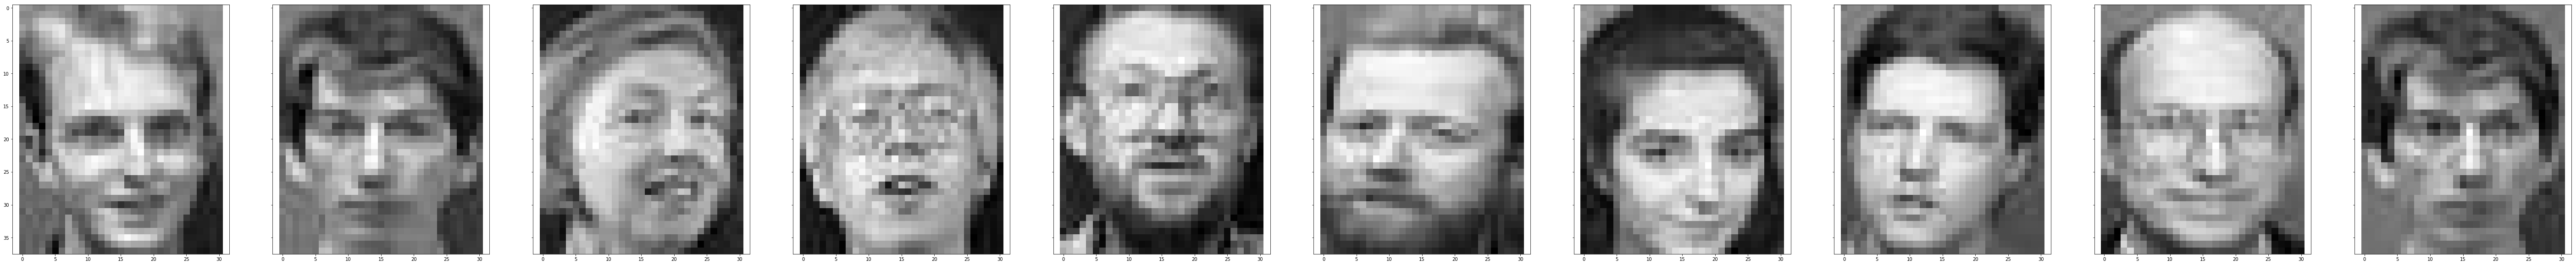

In [52]:
xTr,yTr,xTe,yTe=loaddata("faces.mat")

def plotfaces(X, xdim=38, ydim=31, ):
    n, d = X.shape
    f, axarr = plt.subplots(1, n, sharey=True)
    f.set_figwidth(10 * n)
    f.set_figheight(n)
    
    if n > 1:
        for i in range(n):
            axarr[i].imshow(X[i, :].reshape(ydim, xdim).T, cmap=plt.cm.binary_r)
    else:
        axarr.imshow(X[0, :].reshape(ydim, xdim).T, cmap=plt.cm.binary_r)
plotfaces(xTr[:10, :])


<h4> Implementation </h4>
<p> The following questions will ask you to finish these functions in a pre-defined order. <br></p>

<p>(a) Implement the functions <b><code>innerproduct</code></b> and <b><code>l2distance</code></b>. You may use your own code(s) from the previous project.</p>

<p>(b) Implement the function <b><code>findknn</code></b>, which should find the $k$ nearest neighbors of a set of vectors within a given training data set. The call of 
<pre>
 [I,D]=findknn(xTr,xTe,k);
</pre> 
should result in two matrices $I$ and $D$, both of dimensions $k\times n$, where $n$ is the number of input vectors in <code>xTe</code>. The matrix $I(i,j)$ is the index of the $i^{th}$ nearest neighbor of the vector $xTe(j,:)$. 
So, for example, if we set <code>i=I(1,3)</code>, then <code>xTr(i,:)</code> is the first nearest neighbor of vector <code>xTe(3,:)</code>. The second matrix $D$ returns the corresponding distances. So $D(i,j)$ is the distance of $xTe(j,:)$ to its $i^{th}$ nearest neighbor.
</p>

In [53]:
#<GRADED>
def innerproduct(X,Z=None):
    # function innerproduct(X,Z)
    #
    # Computes the inner-product matrix.
    # Syntax:
    # D=innerproduct(X,Z)
    # Input:
    # X: nxd data matrix with n vectors (rows) of dimensionality d
    # Z: mxd data matrix with m vectors (rows) of dimensionality d
    #
    # Output:
    # Matrix G of size nxm
    # G[i,j] is the inner-product between vectors X[i,:] and Z[j,:]
    #
    # call with only one input:
    # innerproduct(X)=innerproduct(X,X)
    #
    if Z is None: # case when there is only one input (X)
        G = np.dot(X, X.transpose())
    else:  # case when there are two inputs (X,Z)
        Z = Z.transpose()
        if X.shape[1] != Z.shape[0]:
            raise ValueError("Invalid Matricies")
        G = np.dot(X, Z)
    return G

def l2distance(X,Z=None):
    # function D=l2distance(X,Z)
    #
    # Computes the Euclidean distance matrix.
    # Syntax:
    # D=l2distance(X,Z)
    # Input:
    # X: nxd data matrix with n vectors (rows) of dimensionality d
    # Z: mxd data matrix with m vectors (rows) of dimensionality d
    #
    # Output:
    # Matrix D of size nxm
    # D(i,j) is the Euclidean distance of X(i,:) and Z(j,:)
    #
    # call with only one input:
    # l2distance(X)=l2distance(X,X)
    #

    if Z is None:
        return l2distance(X, X)
    else:  # case when there are two inputs (X,Z)
        S = (X*X).sum(axis=1).reshape(-1, 1)
        R = (Z*Z).sum(axis=1)
        G = innerproduct(X, Z)
        D_2 = S -2*G + R
        # print(D[D < 0])
        if X is Z:
            np.fill_diagonal(D_2, 0.0)
        D_2 =  np.sqrt(D_2)
        return D_2
#</GRADED>

In [54]:
eu_dist_matrix = l2distance(xTr, xTe)

In [55]:
xTr.shape

(280, 1178)

In [56]:
xTe.shape

(120, 1178)

In [57]:
eu_dist_matrix.shape

(280, 120)

The $L^2$ distance seems to be doing its job just fine.

In [58]:

def old_findknn(xTr,xTe,k):
    """
    function [indices,dists]=findknn(xTr,xTe,k);
    
    Finds the k nearest neighbors of xTe in xTr.
    
    Input:
    xTr = nxd input matrix with n row-vectors of dimensionality d
    xTe = mxd input matrix with m row-vectors of dimensionality d
    k = number of nearest neighbors to be found
    
    Output:
    indices = kxm matrix, where indices(i,j) is the i^th nearest neighbor of xTe(j,:)
    dists = Euclidean distances to the respective nearest neighbors
    """
    
    eu_dist_matrix = l2distance(xTr, xTe)
    
    
    min_matrix = list()
    index_matrix = list()
    for point in eu_dist_matrix.T: # Transpose here to loop over the **Test** point distances rather than tr
        #Each test point
        index_list = list()
        min_list = list()
        point = list(point)
        for i in range(len(point)):
            #Each distance for the test point
            if k == 0:
                continue
            if len(min_list) < k:
                min_list.append(point[i])
                if len(min_list) is k:
                    min_list.sort()
            else:
                try:
                    if point[i] < min_list[k - 1]:
                        min_list[k - 1] = point[i]
                        min_list.sort()
                except IndexError:
                    print("Index at: " + str(i))
                    print("K is " + str(k))
                    print("Point shape: " + str(len(point)))
                    print("min_list shape: " + str(len(min_list)))
                    raise IndexError("Ooops")
        for num in min_list:
            index_list.append(point.index(num))
        min_matrix.append(min_list)
        index_matrix.append(index_list)
    
    return np.asarray(index_matrix).T, np.asarray(min_matrix).T


In [11]:
a = np.array([1,4,2,3,1,4,5,3]).reshape(2,4)
idx = np.array([1,3])
a[1,(idx)]

array([4, 3])

In [79]:
#<GRADED>
def findknn(xTr, xTe, k):
    """
    function [indices,dists]=findknn(xTr,xTe,k);
    
    Finds the k nearest neighbors of xTe in xTr.
    
    Input:
    xTr = nxd input matrix with n row-vectors of dimensionality d
    xTe = mxd input matrix with m row-vectors of dimensionality d
    k = number of nearest neighbors to be found
    
    Output:
    indices = kxm matrix, where indices(i,j) is the i^th nearest neighbor of xTe(j,:)
    dists = Euclidean distances to the respective nearest neighbors
    """
    
    dists = l2distance(xTr, xTe).T # Transpose here to loop over the **Test** point distances rather than tr

    min_matrix = np.zeros((k, xTe.shape[0])) # init as 0s
    index_matrix = np.zeros((k, xTe.shape[0]), dtype=int) # needs to be int for slicing below! defaults to float
    
    if k > 0:
        for i in range(len(dists)): 
            index_matrix[:,i] = dists[i].argsort()[:k] # find idxs of smallests dists
            min_matrix[:,i] = dists[i,(index_matrix[:,i])] # find corresponding dists

    return index_matrix, min_matrix
#</GRADED>

### Attempting to reduce operations more in the code below. might not be necessary at this point. I may revisit this later.

In [13]:
def opt_findknn(xTr, xTe, k):
    """
    function [indices,dists]=findknn(xTr,xTe,k);
    
    Finds the k nearest neighbors of xTe in xTr.
    
    Input:
    xTr = nxd input matrix with n row-vectors of dimensionality d
    xTe = mxd input matrix with m row-vectors of dimensionality d
    k = number of nearest neighbors to be found
    
    Output:
    indices = kxm matrix, where indices(i,j) is the i^th nearest neighbor of xTe(j,:)
    dists = Euclidean distances to the respective nearest neighbors
    """
    
    dists = l2distance(xTr, xTe)

    min_matrix = np.zeros((k, xTe.shape[0])) # init as 0s
    index_matrix = np.zeros((k, xTe.shape[0]), dtype=int) # needs to be int for slicing below! defaults to float
    
    if k > 0:
        index_matrix = np.argsort
        
        for i in range(len(dists)): 
            index_matrix[:,i] = dists[i].argsort()[:k] # find idxs of smallests dists
            min_matrix[:,i] = dists[i,(index_matrix[:,i])] # find corresponding dists

    return index_matrix, min_matrix

In [14]:
a = np.array([1,8,93,4,5,6,5,4,45,12,3,0]).reshape(3,4)
a

array([[ 1,  8, 93,  4],
       [ 5,  6,  5,  4],
       [45, 12,  3,  0]])

In [15]:
a.argsort(axis=0)

array([[0, 1, 2, 2],
       [1, 0, 1, 0],
       [2, 2, 0, 1]])

In [16]:
tuple(a.argsort(axis=0))

(array([0, 1, 2, 2]), array([1, 0, 1, 0]), array([2, 2, 0, 1]))

In [17]:
a.take(a.argsort(axis=0))

array([[ 1,  8, 93, 93],
       [ 8,  1,  8,  1],
       [93, 93,  1,  8]])

In [18]:
np.take(a,tuple(a.argsort(axis=0)), axis=1)

array([[[ 1,  8, 93, 93],
        [ 8,  1,  8,  1],
        [93, 93,  1,  8]],

       [[ 5,  6,  5,  5],
        [ 6,  5,  6,  5],
        [ 5,  5,  5,  6]],

       [[45, 12,  3,  3],
        [12, 45, 12, 45],
        [ 3,  3, 45, 12]]])

In [19]:
np.where?

In [20]:
np.take(a,a.argsort(axis=0), axis=1)

array([[[ 1,  8, 93, 93],
        [ 8,  1,  8,  1],
        [93, 93,  1,  8]],

       [[ 5,  6,  5,  5],
        [ 6,  5,  6,  5],
        [ 5,  5,  5,  6]],

       [[45, 12,  3,  3],
        [12, 45, 12, 45],
        [ 3,  3, 45, 12]]])

In [21]:
np.take?

We can visualize the 10 nearest training neighbors of some of the test points.

In [22]:
who = 4
k = 10
indices, dists = findknn(xTr,np.array(xTe[who,:], ndmin=2), k)
print (dists.shape)
print(indices.shape)

(10, 1)
(10, 1)


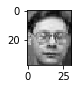

In [23]:
plotfaces(xTe[who,:].reshape(1,-1))

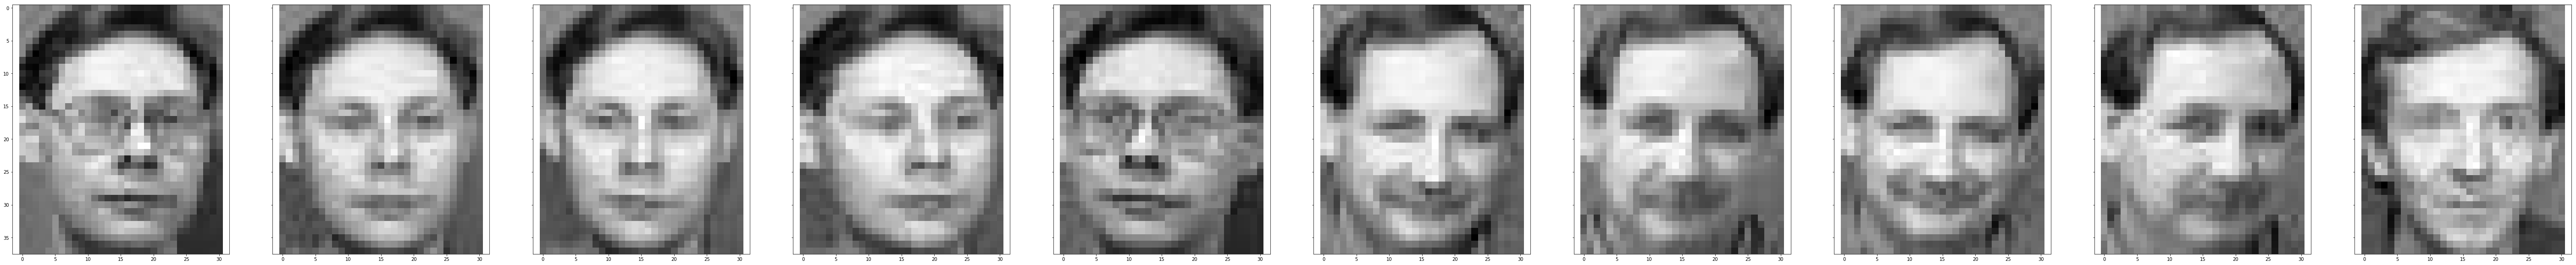

In [24]:
plotfaces(xTr[indices[:,0], :])

<p>(c) The function <b><code>analyze</code></b> should compute various metrics to evaluate a classifier. The call of
<pre>
  result=analyze(kind,truth,preds);
</pre>
should output the <b>accuracy</b> or <b>absolute loss</b> in variable <code>result</code>. The type of output required can be specified in the input argument <code>kind</code> as <code>"abs"</code> or <code>"acc"</code>. The input variables <code>truth</code> and <code>pred</code> should contain vectors of true and predicted labels respectively.
For example, the call
<pre>
>> analyze('acc',[1 2 1 2],[1 2 1 1])
</pre>
should return an accuracy of 0.75. Here, the true labels are 1,2,1,2 and the predicted labels are 1,2,1,1. So the first three examples are classified correctly, and the last one is wrong --- 75% accuracy.
</p>



In [25]:

def old_analyze(kind,truth,preds):
    """
    function output=analyze(kind,truth,preds)         
    Analyses the accuracy of a prediction
    Input:
    kind='acc' classification error
    kind='abs' absolute loss
    (other values of 'kind' will follow later)
    """
    
    truth = truth.flatten()
    preds = preds.flatten()
    
    if len(truth) > len(preds):
        truth = truth[:len(preds)] 
    else:
        preds = preds[:len(truth)]
    
    if kind == 'abs':
        # compute the absolute difference between truth and predictions
        loss = int()
        for i in range(len(truth)):
            if preds[i] != truth[i]:
                loss += abs(truth[i] - preds[i])
    elif kind == 'acc':
        loss = int()
        for i in range(len(truth)):
            if truth[i] != preds[i]:
                loss +=1
        truthScore = zero_one_loss(truth, preds)
        if truthScore != (loss/len(truth)):
            raise Exception("True: " + str(truthScore) + " Ours: " + str(loss/len(truth)))
    return loss/len(truth)


In [78]:
#<GRADED>
def analyze(kind,truth,preds):
    """
    function output=analyze(kind,truth,preds)         
    Analyzes the accuracy of a prediction
    Input:
    kind='acc' classification error
    kind='abs' absolute loss
    (other values of 'kind' will follow later)
    """
    #this function only operates under the assumption that truth and preds are numpy arrays
    
    try:
        truth = truth.flatten()
        preds = preds.flatten()
    except:
        pass
    
    if len(truth) != len(preds):
        raise RuntimeError('len(trush) != len(preds)')
    
    if kind == 'abs':
        # compute the absolute difference between truth and predictions
        a = float(np.abs(truth - preds).sum())
    elif kind == 'acc':
        a = float(np.equal(truth, preds).sum())
    else:
        raise ValueError('choose either "acc" or "abs" for kind')
    return a/float(len(truth))
#</GRADED>

In [27]:
a = np.array([1,2,3,4,3,5,6])
b = np.array([1,2,3,1,3,5,4])

In [28]:
idxs = np.argwhere(a == 3)
idxs.T[0]

array([2, 4])

In [29]:
np.power(a-b,2)

array([0, 0, 0, 9, 0, 0, 4])

In [30]:
(~np.equal(a,b)).sum()

2

In [31]:
(~np.equal(a,b)).sum()/len(a)

0.2857142857142857


<p>(e) Implement the function <b><code>knnclassifier</code></b>, which should perform $k$ nearest neighbor classification on a given test data set. The call <pre>preds=knnclassifier(xTr,yTr,xTe,k)</pre>
should output the predictions for the data in <code>xTe</code> i.e. <code>preds[i]</code> will contain the prediction for <code>xTe[i,:]</code>.</p>

In [106]:
#<GRADED>
def knnclassifier(xTr,yTr,xTe,k):
    """
    function preds=knnclassifier(xTr,yTr,xTe,k);
    
    k-nn classifier 
    
    Input:
    xTr = nxd input matrix with n row-vectors of dimensionality d
    xTe = mxd input matrix with m row-vectors of dimensionality d
    k = number of nearest neighbors to be found
    
    Output:
    
    preds = predicted labels, ie preds(i) is the predicted label of xTe(i,:)
    """
    yTr = np.asanyarray(yTr).flatten()
    xTr = np.asanyarray(xTr)
    xTe = np.asanyarray(xTe)
    indicies_matrix, dist_matrx = findknn(xTr, xTe, k)
    labels = np.zeros(indicies_matrix.shape)
    for i in range(len(indicies_matrix.T)):
        labels[:,i] = yTr[(indicies_matrix.T[i])].T
    preds = mode(labels)[0] # simple mode calc, if tie, takes least (maybe consider different k val in this case)
    
    return preds
#</GRADED>

In [74]:
#<GRADED>
def new_knnclassifier(xTr,yTr,xTe,k):
    """
    function preds=knnclassifier(xTr,yTr,xTe,k);
    
    k-nn classifier 
    
    Input:
    xTr = nxd input matrix with n row-vectors of dimensionality d
    xTe = mxd input matrix with m row-vectors of dimensionality d
    k = number of nearest neighbors to be found
    
    Output:
    
    preds = predicted labels, ie preds(i) is the predicted label of xTe(i,:)
    """
    indicies_matrix, dist_matrx = findknn(xTr, xTe, k)
    preds = np.zeros(indicies_matrix.shape[1])
    for i in range(len(indicies_matrix.T)):
        class_un = np.unique(yTr[(indicies_matrix.T[i])].T)
        labels = yTr[(indicies_matrix.T[i])].T 
        scores = np.zeros(class_un.shape[0])
        for j in range(class_un.shape[0]):
            idxs = np.argwhere(labels == class_un[j])[:,1]
            for idx in idxs:
                scores[j] += (1 / dist_matrx.T[i,idx]**2)
        preds[i] = class_un[np.argmax(scores)]
    return preds
#</GRADED>

In [35]:
# testing weighting system

indicies_matrix, dist_matrx = findknn(xTr, xTe, 10)
preds = np.zeros(indicies_matrix.shape[1])
for i in range(len(indicies_matrix.T)):
    class_un = np.unique(yTr[(indicies_matrix.T[i])].T)
    labels = yTr[(indicies_matrix.T[i])].T 
    scores = np.zeros(class_un.shape[0])
    for j in range(class_un.shape[0]):
        idxs = np.argwhere(labels == class_un[j])[:,1]
        for idx in idxs:
            scores[j] += (1 / dist_matrx.T[i,idx]**2)
    preds[i] = class_un[np.argmax(scores)]
        
preds_1 = preds

indicies_matrix, dist_matrx = findknn(xTr, xTe, k)
labels = np.zeros(indicies_matrix.shape)
for i in range(len(indicies_matrix.T)):
    labels[:,i] = yTr[(indicies_matrix.T[i])].T
preds = stats.mode(labels)[0][0] # simple mode calc, if tie, takes least (maybe consider different k val in this case)

wrong_new = 0
wrong_old = 0
for i in range(len(preds)):
    if preds_1[i] != yTe[i]:
        wrong_new +=1
    if preds[i] != yTe[i]:
        wrong_old +=1
print('wrong_new: ',wrong_new,', wrong_old: ',wrong_old)
    

wrong_new:  14 , wrong_old:  30


In [36]:
indicies_matrix, dist_matrx = findknn(xTr, xTe, 10)
preds = np.zeros(indicies_matrix.shape[1])
for i in range(len(indicies_matrix.T)):
    class_un = np.unique(yTr[(indicies_matrix.T[i])].T)
    labels = yTr[(indicies_matrix.T[i])].T 
    scores = np.zeros(class_un.shape[0])
    for j in range(class_un.shape[0]):
        idxs = np.argwhere(labels == class_un[j])[:,1]
        for idx in idxs:
            scores[j] += (1 / dist_matrx.T[i,idx])
    preds[i] = class_un[np.argmax(scores)]
    
preds

In [229]:
a = np.array([1,45,5,4,5,5,4,3,2,1,1,1,1,1]).reshape(2,7)
b = np.random.randint(2,45,size=200)

In [93]:
def mode(a, axis=0):
    """
    Returns the mode/s (most frequent element/s) of a
    
    Note:
        - This mode function uses a quicksort, which may be inefficient for large arrays
        - Returns None if len(a) <= 0 

    Args:
        a: array_like
            will find the mode (most frequent element) of a
        axis: int
            if nxm array, axis for mode calculation
            defaults to 0

    Returns:
        m: float or array_like
            mode (most frequent element) of a
        frequency: float or array_like
            the frequency (number of occurrences) of the mode
    """
    a = np.asanyarray(a.copy())
    if a.shape[0] == a.size: # is 1xn or nx1
        if a.size == 0:
            return None
        else:
            max_freq = 1
            a.sort()
            m = a[0]
            curr_freq = 1
            for i in range(1, len(a)):
                if a[i] == a[i-1]:
                    curr_freq += 1
                if curr_freq > max_freq:
                    max_freq = curr_freq
                    m = a[i-1]
                if a[i] != a[i-1]:
                    curr_freq = 1
            return m, max_freq
    else: # nxm array
        if axis == 0:
            a = a.T
        l = len(a)
        m = np.zeros(l)
        f = np.zeros(l)
        for i in range(l):
            m[i], f[i] = mode(a[i])
        return m, f
                

In [ ]:
def test_mode(a, axis=0):
    """
    Returns the mode/s (most frequent element/s) of a
    
    Note:
        - This mode function uses a quicksort, which may be inefficient for large arrays
        - Returns None if len(a) <= 0 

    Args:
        a: array_like
            will find the mode (most frequent element) of a
        axis: int
            if nxm array, axis for mode calculation
            defaults to 0

    Returns:
        m: float or array_like
            mode (most frequent element) of a
        frequency: float or array_like
            the frequency (number of occurrences) of the mode
    """
    a = np.asanyarray(a.copy())
    if a.shape[0] == a.size: # is 1xn or nx1
        if a.size == 0:
            return None
        else:
            print(a) ##================================Remove
            max_freq = 1
            a.sort()
            m = a[0]
            curr_freq = 1
            for i in range(1, len(a)):
                if a[i] == a[i-1]:
                    curr_freq += 1
                    print(curr_freq) ##================================Remove
                elif:
                    if curr_freq > max_freq:
                        max_freq = curr_freq
                        
                        m = a[i-1]
                    curr_freq = 1
            return m, max_freq
    else: # nxm array
        if axis == 0:
            a = a.T
        l = len(a)
        m = np.zeros(l)
        f = np.zeros(l)
        for i in range(l):
            m[i], f[i] = mode(a[i])
        return m, f
                

In [242]:
test_1 = np.random.randint(3,10,size=300).reshape(10,30)

In [253]:
test_1

In [248]:
myResult = mode(test_1)[0]
myResult

array([ 7.,  5.,  5.,  3.,  3.,  3.,  7.,  8.,  5.,  4.,  4.,  5.,  4.,
        7.,  5.,  4.,  7.,  4.,  5.,  5.,  5.,  4.,  7.,  3.,  7.,  3.,
        3.,  3.,  8.,  4.])

In [268]:
stats.mode(test_1)[0] == mode(test_1)[0]

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True]], dtype=bool)

In [257]:
scipy_result = stats.mode(test_1)

In [262]:
test_1[:,14]

array([9, 5, 9, 7, 4, 9, 8, 3, 5, 7])

In [275]:
np.zeros(4)
print(test_1.T[14])
print(mode(test_1.T[14].T))

[3 4 5 5 7 7 8 9 9 9]
(9, 3)


In [230]:
stats.mode(a)

ModeResult(mode=array([[1, 2, 1, 1, 1, 1, 1]]), count=array([[1, 1, 1, 1, 1, 1, 1]]))

In [234]:
mode(a)[0]

array([ 1.,  2.,  1.,  1.,  1.,  1.,  1.])

In [233]:
mode(a)

(array([ 1.,  2.,  1.,  1.,  1.,  1.,  1.]),
 array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.]))

In [213]:
a

array([[ 1, 45,  5,  4,  5,  5,  4],
       [ 3,  2,  1,  1,  1,  1,  1]])

# Notes for knnclassifier:
 - [this page](http://www.statsoft.com/Textbook/k-Nearest-Neighbors) gives some info about choosing a classification based on a voting scheme of some sort.
  - also talks about choosing a best value for k

In [23]:
a = np.array([1,2,3,4,3,4,3,2,3,2,1,3])
idx = np.array([1,2,1,3,1,3,3,4]).reshape(2,4)
b = a[(idx)]
b

array([[2, 3, 2, 4],
       [2, 4, 4, 3]])

In [24]:
stats.mode(b, axis=1)[0]

array([[2],
       [4]])

<p>You can compute the actual classification error on the test set by calling
<pre>
>> analyze("acc",yTe,knnclassifier(xTr,yTr,xTe,3))
</pre></p>

<p>(e) This script runs the $k$-nearest neighbor classifier over the faces and digits data set. The faces data set has $40$ classes, the digits data set $10$. What classification accuracy would you expect from a random classifier?</p>

In [25]:
print("Face Recognition: (1-nn)")
xTr,yTr,xTe,yTe=loaddata("faces.mat") # load the data
t0 = time.time()
preds = knnclassifier(xTr,yTr,xTe,1)
result=analyze("acc",yTe,preds)
t1 = time.time()
print("You obtained %.2f%% classification acccuracy in %.4f seconds\n" % (result*100.0,t1-t0))

print("Handwritten digits Recognition: (3-nn)")
xTr,yTr,xTe,yTe=loaddata("digits.mat"); # load the data
t0 = time.time()
preds = knnclassifier(xTr,yTr,xTe,5)
result=analyze("acc",yTe,preds)
t1 = time.time()
print("You obtained %.2f%% classification acccuracy in %.4f seconds\n" % (result*100.0,t1-t0))

Face Recognition: (1-nn)
You obtained 4.17% classification acccuracy in 0.0179 seconds

Handwritten digits Recognition: (3-nn)
You obtained 4.98% classification acccuracy in 2.6167 seconds



<p>(f) (optional) Sometimes a $k$-NN classifier can result in a draw, when the majority vote is not clearly defined. Can you improve your accuracy by falling back onto $k$-NN with lower $k$ in such a case?</p>

<p>(g) Edit the function <b><code>competition</code></b>, which reads in a training and testing set and makes predictions. Inside this function you are free to use any combination or variation of the k-nearest neighbor classifier. Can you beat my submission on our secret training and testing set? </p>

<h4>Evaluation</h4>
<p>For this project, you will be ranked on the following measures:
<ul>
<li>Percentage of test cases passed</li>
<li>Average of:
<ul>
  <li>Accuracy on the faces test dataset and</li>
  <li>Accuracy on the digits test dataset</li>
  <li>Accuracy on the <i>secret</i> test dataset</li>
</ul>
</ul>

</p>

In [101]:
X_train, X_test, y_train, y_test = train_test_split(xTr, yTr, test_size=0.66, random_state=42)

In [ ]:
def old_train_test_splitter(x_train, y_train, train_size = 0.66, prng_seed=42):
    x_train = np.asanyarray(x_train)
    y_train = np.asanyarray(y_train)
    n = len(x_train)
    indices = np.arange(0, n)
    
    np.random.seed(seed=prng_seed)
    np.random.shuffle(indices) # shuffles inplace

    x_train_shuff = x_train[(indices), :]
    y_train_shuff = y_train[(indices)]
    
    num_trains = int(n*train_size)
    
    x_train_new = x_train_shuff[:num_trains, :]
    x_test_new = x_train_shuff[num_trains:, :]
    y_train_new = y_train_shuff[:num_trains]
    y_test_new = y_train_shuff[num_trains:]
    
    return x_train_new, x_test_new, y_train_new, y_test_new

In [126]:
class train_test_splitter:
    
    def __init__(self, x_train, y_train):
        self.x = np.asanyarray(x_train)
        self.y = np.asanyarray(y_train.flatten())
        
        self.y_args = self.y.argsort()
        self.y_sorted = self.y[(self.y_args)]
        self.x_sorted = self.x[(self.y_args), :]
        
        self.data_dict = defaultdict(list)
        [self.data_dict[self.y_sorted[i]].append(self.x_sorted[i]) for i in range(len(self.x_sorted))]
        
    def get_sample(self, training_percent=0.33):
        shuffled_keys = list(self.data_dict.keys())
        random.shuffle(shuffled_keys)
        tr_shuffle_y = shuffled_keys[:int(len(shuffled_keys) * training_percent)]
        te_shuffle_y = shuffled_keys[int(len(shuffled_keys) * training_percent):]
        training_x = []
        training_y = []
        for key in tr_shuffle_y:
            training_x.extend(self.data_dict[key])
            training_y.extend([key] * len(self.data_dict[key]))
        test_x = []
        test_y = []
        for key in te_shuffle_y:
            test_x.extend(self.data_dict[key])
            test_y.extend([key] * len(self.data_dict[key]))
                
        #[training_x.extend(self.data_dict[key]) for key in training_y]
        #test_x = []
        #test_x.extend(self.data_dict[key]) for key in test_y]
        return np.asanyarray(training_x), np.asanyarray(training_y), np.asanyarray(test_x), np.asanyarray(test_y)
        

In [127]:
test_y = np.random.choice(self.data_dict.keys(), size=int(len(self.data_dict.keys())*self.test_percent), replace=False)
train_y = [y for y in data_dict.keys() if y not in test_y]

NameError: name 'self' is not defined

In [128]:
tt_split = train_test_splitter(c, c_labels)

In [129]:
tr_x, tr_y, te_x, te_y = tt_split.get_sample()
print(te_y)
print(tr_y)

[ 4  9  9  8  8  8  8  5  5  5 15 15 15 10 10 13 13 13 14 14 14  6 17 17 17
 12 12 12 12]
[ 7 18 18 18 11 11 11 11 16 16 16]


In [7]:
c = np.random.randint(0,20,size=200).reshape(40,5)

In [9]:
c[:7,:]

array([[18, 13,  1,  3, 11],
       [ 8, 13,  9, 16, 15],
       [ 7, 15, 19, 15, 12],
       [14,  5, 15, 18, 17],
       [16,  3, 10, 12,  0],
       [ 6,  7, 12,  3,  8],
       [19, 18, 15, 12, 13]])

In [28]:
d = {1:4, 3:5}

In [29]:
d.keys()

dict_keys([1, 3])

In [33]:
list(d.keys())

[1, 3]

In [11]:
c_labels = np.random.randint(4,19, size=40)

In [ ]:
np.c_labels

In [124]:
c[:2,:]

array([[12,  3,  1,  2, 10],
       [ 4, 13,  0, 12, 11]])

In [125]:
c[2:,:]

array([[11,  0, 10,  2, 15],
       [ 2,  3,  6, 19,  7]])

In [115]:
c_a = np.arange(0, len(c))

In [116]:
np.random.shuffle(c_a)

In [117]:
c_a

array([1, 3, 2, 0])

In [119]:
c[(c_a),:]

array([[ 4, 13,  0, 12, 11],
       [ 2,  3,  6, 19,  7],
       [11,  0, 10,  2, 15],
       [12,  3,  1,  2, 10]])

In [141]:
d = np.random.randint(1,4,size=4)
d

array([2, 1, 1, 3])

In [123]:
d[(c_a)]

array([2, 3, 2, 1])

In [96]:
#<GRADED>
def competition(xTr,yTr,xTe):
    """
    function preds=competition(xTr,yTr,xTe);
    
    A classifier that outputs predictions for the data set xTe based on 
    what it has learned from xTr,yTr
    
    Input:
    xTr = nxd input matrix with n column-vectors of dimensionality d
    xTe = mxd input matrix with n column-vectors of dimensionality d
    
    Output:
    
    preds = predicted labels, ie preds(i) is the predicted label of xTe(i,:)
    """
    #Split Test data into train and test
    X_train, X_test, y_train, y_test = train_test_splitter(xTr, yTr, train_size=0.66, prng_seed=42)
    
    #we can argmax on k evaluated by our loss percentage
    best_k = (0, 0)
    print(y_train)
    for k_curr in range(1, 40):
        preds = knnclassifier(X_train, y_train, X_test, k_curr)
        result = analyze("acc",y_test,preds)
        if result > best_k[1]:
            best_k = (k_curr, result)
    preds = knnclassifier(xTr, yTr, xTe, best_k[0])
    
    return preds
#</GRADED>

In [195]:
predictions = competition(xTr, yTr, xTe)

In [196]:
analyze(kind='acc', truth=yTe, preds=predictions)

0.9583333333333334

In [123]:
def testing_tt_splitter(xTr,yTr,xTe, yTe):
    """
    function preds=competition(xTr,yTr,xTe);
    
    A classifier that outputs predictions for the data set xTe based on 
    what it has learned from xTr,yTr
    
    Input:
    xTr = nxd input matrix with n column-vectors of dimensionality d
    xTe = mxd input matrix with n column-vectors of dimensionality d
    
    Output:
    
    preds = predicted labels, ie preds(i) is the predicted label of xTe(i,:)
    """
    #Split Test data into train and test
    tt_splitter = train_test_splitter(xTr, yTr)
    
    X_train, y_train, X_test, y_test = tt_splitter.get_sample()
    
    #we can argmax on k evaluated by our loss percentage
    best_k = (0, 0)
    for k_curr in range(1, 40):
        preds = knnclassifier(X_train, y_train, X_test, k_curr)
        result = analyze("acc",y_test,preds)
        print()
        if result > best_k[1]:
            best_k = (k_curr, result)
    print(yTr.flatten())
    preds = knnclassifier(xTr, yTr.flatten(), xTe, best_k[0])
    
    
    pct_wrong = (~np.equal(preds, yTe)).sum() / float(len(preds))
    return pct_wrong

In [124]:
testing_tt_splitter(xTr, yTr, xTe, yTe)

[ 19.  19.  19.  19.  19.  19.  11.  24.   7.   7.   7.   7.  19.   7.  23.
  23.  38.  38.  38.  38.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.
  12.  12.  21.  12.  12.  23.   7.  23.  24.  24.   7.  24.  19.  24.  21.
  21.  24.  24.  21.  12.  12.  12.  12.  12.  12.  12.  14.  14.  14.  14.
  12.  12.  12.  38.  12.  12.  38.  12.  12.  12.  14.  19.  14.  14.  14.
  14.  19.  19.  19.  19.  19.   7.  19.  19.  24.  24.  24.  24.  24.  24.
  19.  21.  21.  38.  21.  21.  38.  23.  22.  22.  22.  22.  22.  22.  22.
  22.  22.  22.  22.  22.  22.  22.  12.  12.  12.  12.  12.  12.  12.  12.
  38.  21.  12.  23.  12.  12.  24.  24.  24.  24.  19.  24.  24.  22.  22.
  21.  21.  22.  21.  22.  19.  12.  21.  21.  12.  12.  22.  23.  23.  21.
  23.  38.  21.  38.  12.  38.  12.  38.  23.  38.  38.  21.  21.  21.  22.
  21.  21.  21.  21.  21.  21.  21.  21.  21.  21.  21.  21.  21.  21.  21.
  21.  38.  12.  19.  12.  12.  19.  12.  12.]
[ 19.  11.  19.  19.  19.  19.  11.  24. 

TypeError: 'NoneType' object is not subscriptable

In [65]:
yTr.flatten()

In [120]:
yTr = np.asanyarray(yTr).flatten()
xTr = np.asanyarray(xTr)
xTe = np.asanyarray(xTe)
indicies_matrix, dist_matrx = findknn(xTr, xTe, 0)
labels = np.zeros(indicies_matrix.shape)
for i in range(len(indicies_matrix.T)):
    labels[:,i] = yTr[(indicies_matrix.T[i])].T
preds = mode(labels)[0] # simple mode calc, if tie, takes least (maybe consider different k val in this case)

preds


TypeError: 'NoneType' object is not subscriptable

In [ ]:
class other_train_test_splitter:
    
    def __init__(self, x_train, y_train):
        self.x = np.asanyarray(x_train)
        self.y = np.asanyarray(y_train)
        
        self.y_args = self.y.argsort()
        self.y_sorted = self.y[(self.y_args)]
        self.x_sorted = self.x[(self.y_args), :]
        
        self.data_dict = defaultdict(list)
        [self.data_dict[self.y_sorted[i]].append(i) for i in range(len(self.x_sorted))]
        
    def get_sample(self, training_percent=0.33):
        ys = list(self.data_dict.keys())
        test_labels = np.random.choice(ys, size=int(len(self.data_dict.keys())*self.test_percent), replace=False)
        train_labels = [y for y in data_dict.keys() if y not in test_y]
        return training_x, training_y, test_x, test_y
        